In [3]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/pygad/pygad.py:744: UserWarning: The percentage of genes to mutate (mutation_percent_genes=20) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")



Best Evolved Prompt (Using Real Dataset Fragments):
 Use analogies and storytelling Be concise and beginner-friendly Add a summary at the end You are an expert physicist
Fitness Score: 4


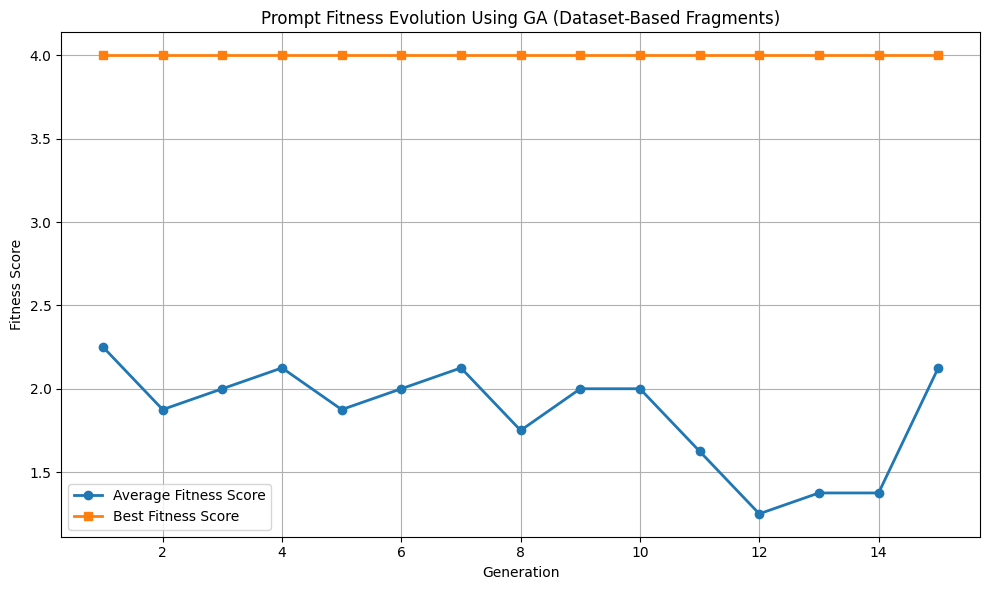

In [5]:
import pandas as pd
import pygad
import numpy as np
import matplotlib.pyplot as plt

# Load the original dataset from user upload
df = pd.read_csv('/content/sample_data/Simulated_Prompt_Fitness_Data.csv')

# Extract prompt fragments from the dataset dynamically
# We'll use all unique fragments seen in the dataset
fragment_set = set()
for prompt in df['Prompt']:
    fragments = prompt.split('. ')
    for frag in fragments:
        clean_frag = frag.strip().strip('.')  # remove trailing punctuation
        if clean_frag and clean_frag not in fragment_set:
            fragment_set.add(clean_frag)

prompt_fragments = list(fragment_set)

# Define base task again
task_input = "Explain the concept of quantum computing in simple terms."

# Redefine chromosome decoding using new fragment pool
def decode_chromosome(solution):
    indices = [int(round(i)) % len(prompt_fragments) for i in solution]
    selected = [prompt_fragments[i] for i in indices]
    return " ".join(selected)

# Reuse previous key terms as simulated fitness criteria
key_terms = ["expert physicist", "examples", "summary", "beginner-friendly", "analogies"]
generation_scores = []

def fitness_func(ga_instance, solution, solution_idx):
    prompt_text = decode_chromosome(solution).lower()
    score = sum(term in prompt_text for term in key_terms)
    return score

def on_generation(ga_instance):
    gen = ga_instance.generations_completed
    avg = np.mean(ga_instance.last_generation_fitness)
    best = np.max(ga_instance.last_generation_fitness)
    generation_scores.append((gen, avg, best))

# Run GA using fragments from actual dataset
ga_instance = pygad.GA(
    num_generations=15,
    num_parents_mating=5,
    sol_per_pop=8,
    num_genes=4,
    gene_space={'low': 0, 'high': len(prompt_fragments)-1},
    fitness_func=fitness_func,
    on_generation=on_generation,
    parent_selection_type="rank",
    keep_parents=2,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20
)

# Execute GA run
ga_instance.run()

# Decode best solution
solution, solution_fitness, _ = ga_instance.best_solution()
best_prompt = decode_chromosome(solution)

# Output best result
print("\nBest Evolved Prompt (Using Real Dataset Fragments):\n", best_prompt)
print("Fitness Score:", solution_fitness)

# Plot generation score evolution
generations = [x[0] for x in generation_scores]
avg_scores = [x[1] for x in generation_scores]
best_scores = [x[2] for x in generation_scores]

plt.figure(figsize=(10, 6))
plt.plot(generations, avg_scores, marker='o', label='Average Fitness Score', linewidth=2)
plt.plot(generations, best_scores, marker='s', label='Best Fitness Score', linewidth=2)
plt.title("Prompt Fitness Evolution Using GA (Dataset-Based Fragments)")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-6-d30526438319>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_df_n, x='Fitness Score', y='Prompt', palette='viridis')


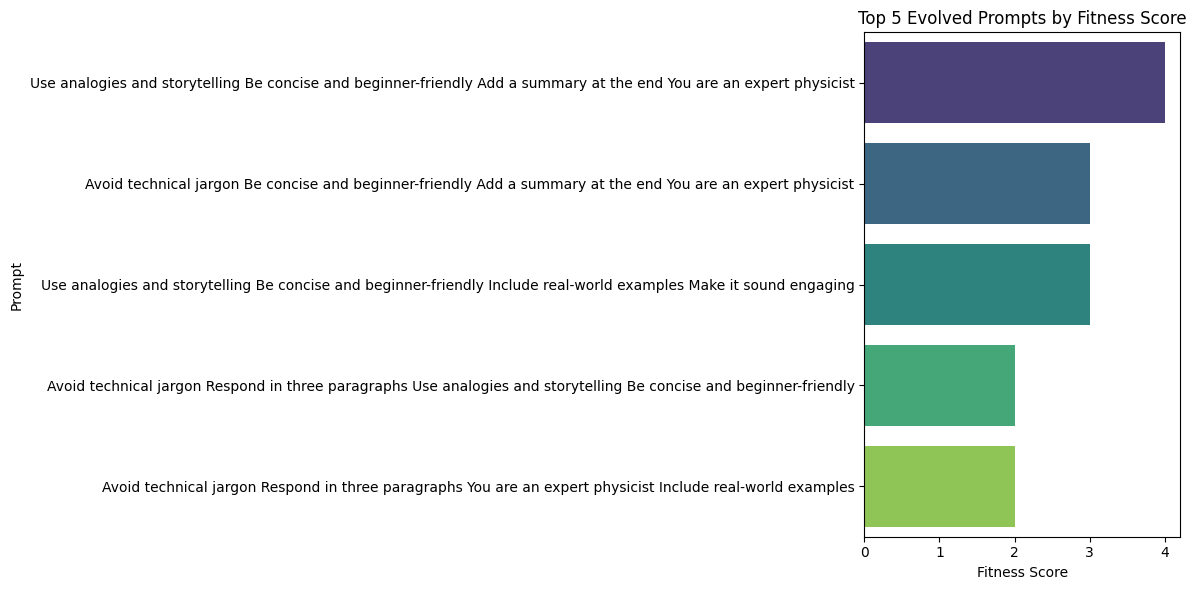


Top Prompts:

1. [Score: 4] Use analogies and storytelling Be concise and beginner-friendly Add a summary at the end You are an expert physicist
2. [Score: 3] Avoid technical jargon Be concise and beginner-friendly Add a summary at the end You are an expert physicist
3. [Score: 3] Use analogies and storytelling Be concise and beginner-friendly Include real-world examples Make it sound engaging
4. [Score: 2] Avoid technical jargon Respond in three paragraphs Use analogies and storytelling Be concise and beginner-friendly
5. [Score: 2] Avoid technical jargon Respond in three paragraphs You are an expert physicist Include real-world examples


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all solutions & scores from last generation
all_prompts = []
fitness_scores = []

for solution in ga_instance.population:
    decoded_prompt = decode_chromosome(solution)
    score = fitness_func(None, solution, 0)
    all_prompts.append(decoded_prompt)
    fitness_scores.append(score)

# Create dataframe
top_df = pd.DataFrame({
    'Prompt': all_prompts,
    'Fitness Score': fitness_scores
})

# Sort and take top N prompts
top_df = top_df.sort_values(by='Fitness Score', ascending=False).reset_index(drop=True)
top_n = 5  # You can increase as needed
top_df_n = top_df.head(top_n)

# Visualize as a barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_df_n, x='Fitness Score', y='Prompt', palette='viridis')
plt.title(f"Top {top_n} Evolved Prompts by Fitness Score")
plt.xlabel("Fitness Score")
plt.ylabel("Prompt")
plt.tight_layout()
plt.show()

# Print Top Prompts Textually
print("\nTop Prompts:\n")
for idx, row in top_df_n.iterrows():
    print(f"{idx+1}. [Score: {row['Fitness Score']}] {row['Prompt']}")
